In [1]:
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import gsw
import numpy as np
import xscale.signal.fitting as xfit
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 10)
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['legend.fontsize'] = 16

In [2]:
%run plot.py
%run preprocessing.py
%run thermodynamics.py
%run geometry.py

In [3]:
argo_TS = open_argo_TS('/data/OBS/ARGO/RG_ArgoClim_Temperature_2017.nc',
                       '/data/OBS/ARGO/RG_ArgoClim_Salinity_2017.nc')

In [4]:
def get_mean_N_profile(ds, region='NCAL'):
    # TS Climatology from ARGO
    ds_region = get_data_over_region(ds, region=region)
    mean_argo_profile = ds_region.mean(('lat', 'lon'), keep_attrs=True)
    profile_by_season = mean_argo_profile.groupby('time.season').mean('time', keep_attrs=True).compute()
    # Compute profiles average over season and all year
    profile_annual = mean_argo_profile.mean('time', keep_attrs=True).compute()
    profile_cool = profile_by_season.sel(season=['JJA', 'SON']).mean('season', keep_attrs=True)
    profile_warm = profile_by_season.sel(season=['DJF', 'MAM']).mean('season', keep_attrs=True)
    ds_profile = xr.concat([profile_annual, profile_cool, profile_warm], dim=xr.IndexVariable('season', ['Annual', 'Cool', 'Warm']))
    # Compute sigma0 and N2 profiles
    density = sigma0(ds_profile['Salinity'], ds_profile['Temperature'], ds_profile['p'],
                         lat=ds_profile.lat_mean, lon=ds_profile.lon_mean)
    N2, p_mid = Nsquared(ds_profile['Salinity'], ds_profile['Temperature'], ds_profile['p'],
                             lat=ds_profile.lat_mean, lon=ds_profile.lon_mean)
    axis = ds_profile['Salinity'].get_axis_num('season')
    N = xr.DataArray(np.sqrt(N2), dims=('season', 'p_mid'), coords={'p_mid': p_mid.mean(axis=axis), 'season': ds_profile.season})
    ds_profile = ds_profile.assign(N=N, sigma0=xr.DataArray(density, coords= ds_profile['Salinity'].coords), 
                                   lon_mean=ds_profile.lon_mean, lat_mean=ds_profile.lat_mean)
    return ds_profile

In [5]:
def fit_exponential_profile(N, axis=None):
    from scipy.stats import linregress
    slope, intercept = linregress(N['p_mid'], np.log(N))
    b = 1. / slope
    N0 = np.exp(intercept)
    return N0, b

In [6]:
profile_NCAL = get_mean_N_profile(argo_TS, region='NCAL')
profile_ECAL = get_mean_N_profile(argo_TS, region='ECAL')
profile_SCAL = get_mean_N_profile(argo_TS, region='SCAL')
profile_VAUB = get_mean_N_profile(argo_TS, region='VAUB')
profiles = xr.concat([profile_NCAL, profile_ECAL, profile_SCAL, profile_VAUB], 
                     dim=xr.IndexVariable('region', ['NCAL', 'ECAL', 'SCAL', 'VAUB']))

In [7]:
slope, offset = xfit.linreg(np.log(profiles['N']).chunk(), dim='p_mid')
b = abs(1. / slope)
b.attrs.long_name = "e-folding scale of N(z)"
N0 = np.exp(offset)
N0.attrs.long_name = "Surface-extrapolated buoyancy frequency"
Nexp = N0 * np.exp(- profiles['p_mid'] / b)
Nexp.attrs.long_name = "Exponential N(z) profile" 

/Users/serazin/anaconda3/envs/jplab/lib/python3.7/site-packages/dask/array/linalg.py:1107: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.array([0, 1], dtype=b.dtype))


In [8]:
profiles = profiles.assign(b=b, N0=N0, Nexp=Nexp)

In [9]:
profiles

<xarray.Dataset>
Dimensions:      (p: 58, p_mid: 57, region: 4, season: 3)
Coordinates:
  * p            (p) float32 2.5 10.0 20.0 30.0 ... 1700.0 1800.0 1900.0 1975.0
  * season       (season) object 'Annual' 'Cool' 'Warm'
  * p_mid        (p_mid) float64 6.25 15.0 25.0 ... 1.75e+03 1.85e+03 1.938e+03
  * region       (region) object 'NCAL' 'ECAL' 'SCAL' 'VAUB'
Data variables:
    Temperature  (region, season, p) float32 27.593863 27.568573 ... 2.3578377
    Salinity     (region, season, p) float32 34.917522 34.921825 ... 34.638084
    N            (region, season, p_mid) float64 0.003918 0.00569 ... 0.001436
    lat_mean     (region) float64 -16.17 -22.25 -25.0 -21.0
    lon_mean     (region) float64 165.2 174.5 166.5 166.3
    sigma0       (region, season, p) float64 22.47 22.48 22.51 ... 27.66 27.67
    N0           (region, season) float64 dask.array<shape=(4, 3), chunksize=(4, 3)>
    Nexp         (region, season, p_mid) float64 dask.array<shape=(4, 3, 57), chunksize=(4, 3, 57)>


In [10]:
profiles.to_netcdf('/data/RESULTS/VERTICAL_PROFILES/Mean_ARGO_profiles_around_New_Caledonia.nc')

## Figure 6a: Mean T/S profiles over the different regions from ARGO

In [16]:
def plot_TS_profile_summer_vs_winter(profiles, region='NCAL', ylim=[0, 500], 
                                     Slim=[34, 36], Tlim=[5, 30], **kwargs):
    axT = plt.gca()
    axS = plt.twiny(axT)
    profile = profiles.sel(region=region)
    axT.plot(profile['Temperature'].sel(season='Cool'), profile['p'], 
             label='T Cool', color='C0', **kwargs)
    axT.plot(profile['Temperature'].sel(season='Warm'), profile['p'], 
             label='T Warm', color='C0', ls='--', **kwargs)  
    axS.plot(profile['Salinity'].sel(season='Cool'), profile['p'], 
             label='S Cool', color='C3', **kwargs)
    axS.plot(profile['Salinity'].sel(season='Warm'), profile['p'], 
             label='S Warm', color='C3', ls='--', **kwargs)
    # Custom Temperature axis
    axT.set_xlabel(r'$T\,(^\circ C)$', color='C0')
    axT.tick_params(axis='x', colors='C0')
    axT.get_xaxis().set_major_locator(plt.MultipleLocator(5))
    axT.get_xaxis().set_minor_locator(plt.MultipleLocator(1)) 
    axT.set_xlim(Tlim)
    # Custom Salinity axis
    axS.set_xlabel(r'$S\,(psu)$', color='C3')
    axS.tick_params(axis='x', colors='C3')
    axS.get_xaxis().set_major_locator(plt.MultipleLocator(0.5))
    axS.get_xaxis().set_minor_locator(plt.MultipleLocator(0.1))     
    axS.set_xlim(Slim)
    # Custom vertical axis
    axT.set_ylim(ylim)
    axT.get_yaxis().set_major_locator(plt.MultipleLocator(50))
    axT.get_yaxis().set_minor_locator(plt.MultipleLocator(10)) 
    axT.invert_yaxis()
    axT.grid(axis='y')
    axT.set_ylabel('Depth (m)')
    plt.tight_layout()

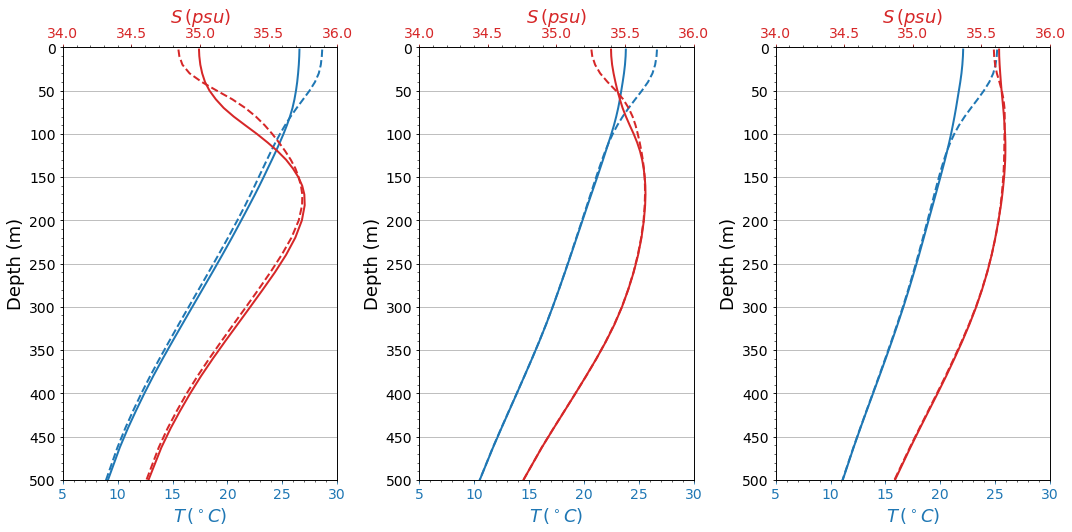

In [17]:
plt.figure(figsize=(15, 7.5))
plt.subplot(131)
plot_TS_profile_summer_vs_winter(profiles, region='NCAL', lw=2)
plt.subplot(132)
plot_TS_profile_summer_vs_winter(profiles, region='ECAL', lw=2)
plt.subplot(133)
plot_TS_profile_summer_vs_winter(profiles, region='SCAL', lw=2)
plt.savefig('../Figures/Fig_6a-TS_profiles.png', dpi=300, bbox_inches='tight')

## Figure 6b: Mean density and N profiles over the different regions from ARGO

In [20]:
def plot_sigma0_N_profile_summer_vs_winter(profiles, region='NCAL', ylim=[0, 500], **kwargs):
    axrho = plt.gca()
    axN = plt.twiny(axrho)
    profile = profiles.sel(region=region)  
    axrho.plot(profile['sigma0'].sel(season='Cool'), profile['p'], 
               label='Cool', color='C2', **kwargs)
    axrho.plot(profile['sigma0'].sel(season='Warm'), profile['p'], label='Warm', 
               color='C2', ls='--', **kwargs)  
    axN.plot(1e2 * profile['N'].sel(season='Cool'),  profile['p_mid'], 
              label='Cool', color='C1', **kwargs)
    axN.plot(1e2 * profile['N'].sel(season='Warm'), profile['p_mid'], label='Warm', 
              color='C1', ls='--', **kwargs)
    # Custom density axis
    axrho.set_xlabel(r'$\sigma_0\,(kg.m^{-3})$', color='C2')
    axrho.tick_params(axis='x', colors='C2')
    axrho.set_xlim([21, 27])
    axrho.get_xaxis().set_minor_locator(plt.MultipleLocator(0.1))    
    # Custom N2 axis
    axN.set_xlabel(r'$N\,10^{-2}\,(s^{-1})$', color='C1')
    axN.tick_params(axis='x', colors='C1') 
    axN.set_xlim([0, 2.0])
    axN.get_xaxis().set_minor_locator(plt.MultipleLocator(0.1)) 
    # Add an horizontal line corresponding to the maximum MLD depth
    xmin, xmax = axN.get_xlim()   
    #axN.hlines(max_mld, xmin, xmax, color='black', lw=1) 
    # Custom vertical axis
    axN.set_ylim(ylim)
    axN.get_yaxis().set_major_locator(plt.MultipleLocator(50))
    axN.get_yaxis().set_minor_locator(plt.MultipleLocator(10)) 
    axN.invert_yaxis()
    axrho.grid(axis='y')
    axrho.set_ylabel('Depth (m)')
    plt.tight_layout()

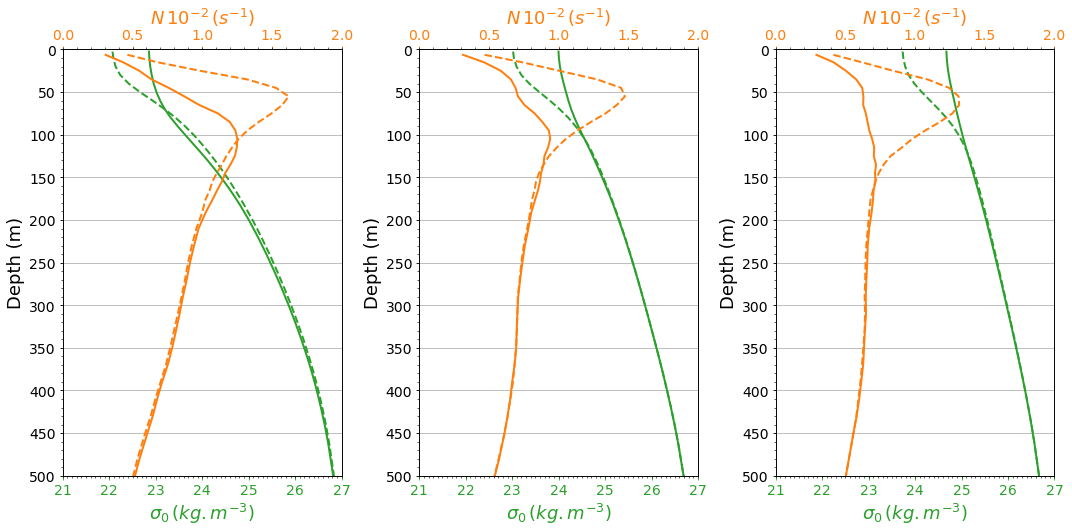

In [21]:
plt.figure(figsize=(15, 7.5))
plt.subplot(131)
plot_sigma0_N_profile_summer_vs_winter(profiles, region='NCAL', lw=2)
plt.ylabel('Depth (m)')
plt.subplot(132)
plot_sigma0_N_profile_summer_vs_winter(profiles, region='ECAL', lw=2)
plt.subplot(133)
plot_sigma0_N_profile_summer_vs_winter(profiles, region='SCAL', lw=2)
plt.savefig('../Figures/Fig_6b-density_profiles.png', dpi=300, bbox_inches='tight')

## Figure 6: Concatenate Fig. 6a and Fig. 6b
Imagemagick is used to concatenate Fig. 6a and Fig. 6b into one figure

In [22]:
%%system
montage ../Figures/Fig_6a*.png ../Figures/Fig_6b*.png -geometry 2048x1024 -tile 1x2 -quality 100 ../Figures/Fig_6-ARGO_vertical_profiles.png
#rm Figures/temp*.png

[]